# Women's Clothing Recommendation Prediction with Interpretable AI

**Student Name:** Georgios Kitsakis

**Course:** Advanced Customer Analytics

**Assignment:** Interpretable Predictions - 2025

---

## Dataset

**Source:** Women's E-Commerce Clothing Reviews  
**Link:** https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews  
**Size:** 23,486 customer reviews

**Features:**
- Numeric: Age, Rating (1-5), Positive Feedback Count
- Categorical: Division Name, Department Name, Class Name
- Text: Review Text, Review Title
- **Target**: Recommended IND (1 = Recommended, 0 = Not Recommended)

**Prediction Task:** Can we predict if a customer will **recommend** a clothing item based on their demographics, product attributes, and review sentiment?

---

## 1. Setup and Imports

In [1]:
!pip install dice-ml scikit-learn pandas numpy matplotlib seaborn xgboost lime shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

import dice_ml
import xgboost as xgb

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Setup complete!")


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Setup complete!


## 2. Load Dataset

In [2]:
import kagglehub

# Download Women's E-Commerce Clothing Reviews dataset
path = kagglehub.dataset_download("nicapotato/womens-ecommerce-clothing-reviews")
print(f"Dataset path: {path}")

Dataset path: C:\Users\admin\.cache\kagglehub\datasets\nicapotato\womens-ecommerce-clothing-reviews\versions\1


## 3. Combine and Explore Data

In [3]:
import os

# Load the Women's Clothing Reviews dataset
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print(f"CSV files found: {csv_files}")

clothing_df = pd.read_csv(os.path.join(path, csv_files[0]))

print(f"Total reviews: {len(clothing_df):,}")
print(f"Columns: {clothing_df.columns.tolist()}")
print(f"\nDataset shape: {clothing_df.shape}")
print(f"\nFirst few rows:")
clothing_df.head()

CSV files found: ['Womens Clothing E-Commerce Reviews.csv']
Total reviews: 23,486
Columns: ['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']

Dataset shape: (23486, 11)

First few rows:


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## 4. Exploratory Data Analysis

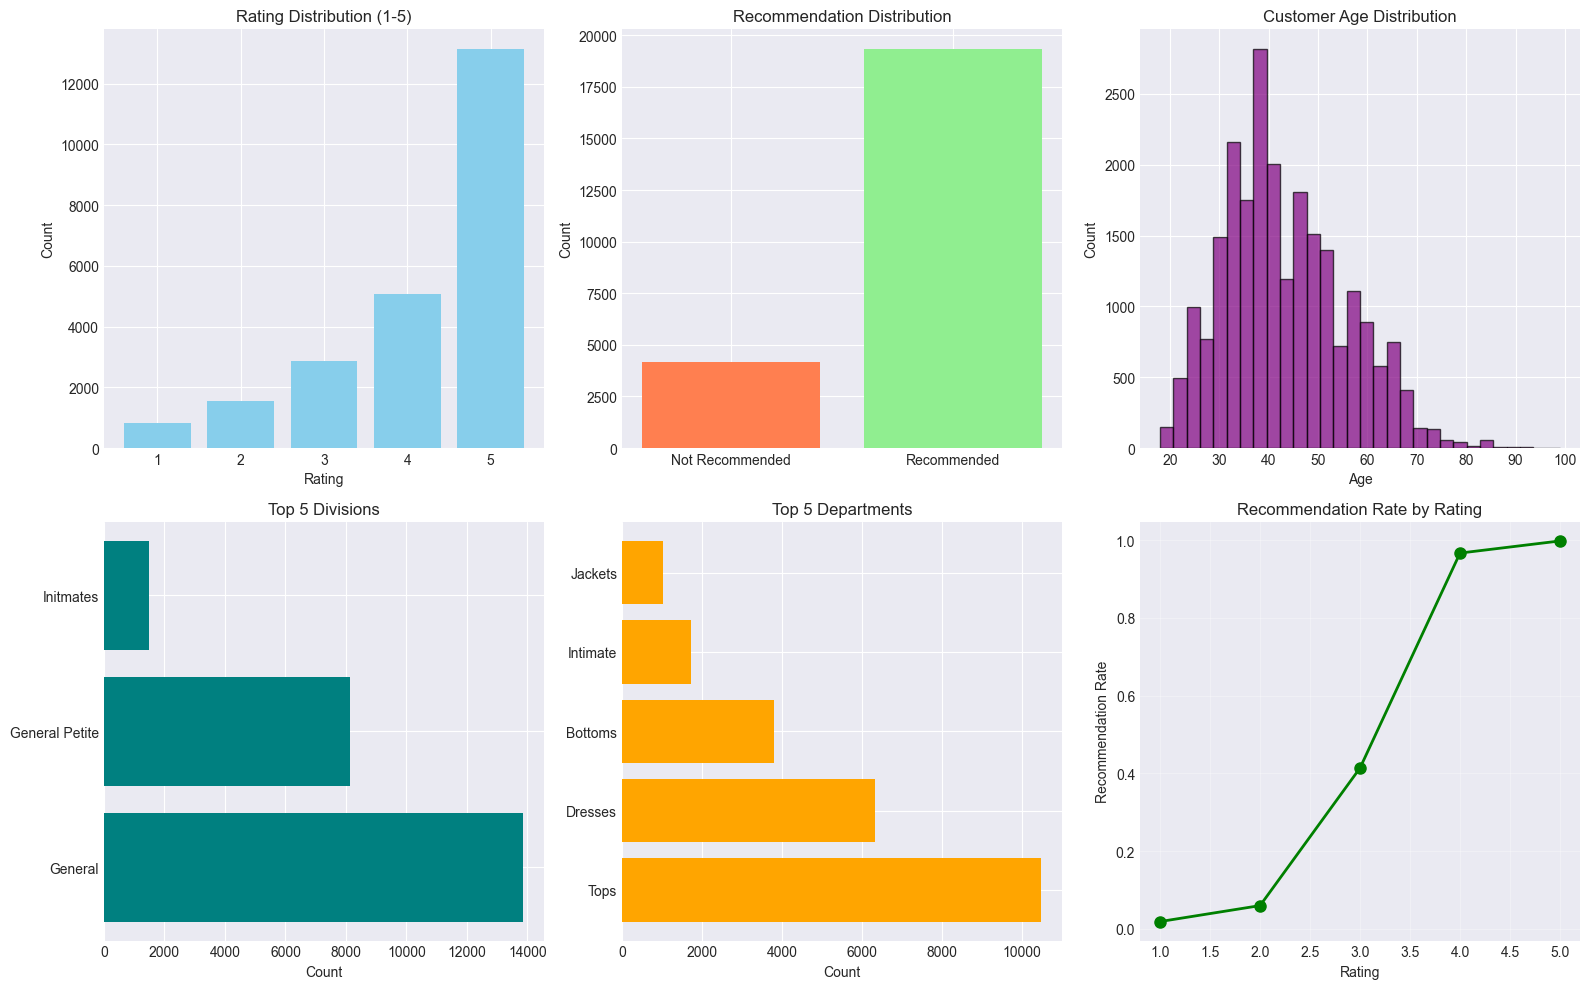


Key Statistics:
  Recommendation Rate: 82.2%
  Average Rating: 4.20
  Average Age: 43.2


In [4]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Rating distribution
axes[0, 0].bar(clothing_df['Rating'].value_counts().sort_index().index,
               clothing_df['Rating'].value_counts().sort_index().values, color='skyblue')
axes[0, 0].set_title('Rating Distribution (1-5)')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# Recommended distribution
rec_counts = clothing_df['Recommended IND'].value_counts()
axes[0, 1].bar(['Not Recommended', 'Recommended'],
               [rec_counts.get(0, 0), rec_counts.get(1, 0)],
               color=['coral', 'lightgreen'])
axes[0, 1].set_title('Recommendation Distribution')
axes[0, 1].set_ylabel('Count')

# Age distribution
axes[0, 2].hist(clothing_df['Age'].dropna(), bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Customer Age Distribution')
axes[0, 2].set_xlabel('Age')
axes[0, 2].set_ylabel('Count')

# Top Divisions
if 'Division Name' in clothing_df.columns:
    top_divisions = clothing_df['Division Name'].value_counts().head(5)
    axes[1, 0].barh(range(len(top_divisions)), top_divisions.values, color='teal')
    axes[1, 0].set_yticks(range(len(top_divisions)))
    axes[1, 0].set_yticklabels(top_divisions.index)
    axes[1, 0].set_title('Top 5 Divisions')
    axes[1, 0].set_xlabel('Count')

# Top Departments
if 'Department Name' in clothing_df.columns:
    top_depts = clothing_df['Department Name'].value_counts().head(5)
    axes[1, 1].barh(range(len(top_depts)), top_depts.values, color='orange')
    axes[1, 1].set_yticks(range(len(top_depts)))
    axes[1, 1].set_yticklabels(top_depts.index)
    axes[1, 1].set_title('Top 5 Departments')
    axes[1, 1].set_xlabel('Count')

# Rating vs Recommendation
if 'Recommended IND' in clothing_df.columns:
    rec_by_rating = clothing_df.groupby('Rating')['Recommended IND'].mean()
    axes[1, 2].plot(rec_by_rating.index, rec_by_rating.values, marker='o', linewidth=2, markersize=8, color='green')
    axes[1, 2].set_title('Recommendation Rate by Rating')
    axes[1, 2].set_xlabel('Rating')
    axes[1, 2].set_ylabel('Recommendation Rate')
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Statistics:")
print(f"  Recommendation Rate: {clothing_df['Recommended IND'].mean()*100:.1f}%")
print(f"  Average Rating: {clothing_df['Rating'].mean():.2f}")
print(f"  Average Age: {clothing_df['Age'].mean():.1f}")

## 5. Feature Engineering

In [5]:
def preprocess_data(df):
    df = df.copy()

    # Handle missing values
    df = df.dropna(subset=['Recommended IND'])
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Rating'] = df['Rating'].fillna(3)
    df['Positive Feedback Count'] = df['Positive Feedback Count'].fillna(0)
    df['Review Text'] = df['Review Text'].fillna('')
    df['Title'] = df['Title'].fillna('')

    # Text features
    df['review_length'] = df['Review Text'].str.len()
    df['review_word_count'] = df['Review Text'].str.split().str.len()
    df['title_length'] = df['Title'].str.len()
    df['has_review'] = (df['review_length'] > 0).astype(int)

    # Clean categorical features
    df['Division Name'] = df['Division Name'].fillna('Unknown')
    df['Department Name'] = df['Department Name'].fillna('Unknown')
    df['Class Name'] = df['Class Name'].fillna('Unknown')

    # Product-level aggregates
    clothing_stats = df.groupby('Clothing ID').agg({
        'Rating': ['mean', 'count', 'std'],
        'Recommended IND': 'mean',
        'Positive Feedback Count': 'mean'
    }).reset_index()
    clothing_stats.columns = ['Clothing ID', 'product_avg_rating', 'product_num_reviews',
                               'product_rating_std', 'product_rec_rate', 'product_avg_feedback']
    clothing_stats['product_rating_std'] = clothing_stats['product_rating_std'].fillna(0)
    df = df.merge(clothing_stats, on='Clothing ID', how='left')

    # Division-level aggregates
    division_stats = df.groupby('Division Name').agg({
        'Rating': 'mean',
        'Recommended IND': 'mean',
        'Age': 'mean'
    }).reset_index()
    division_stats.columns = ['Division Name', 'division_avg_rating', 'division_rec_rate', 'division_avg_age']
    df = df.merge(division_stats, on='Division Name', how='left')

    # Department-level aggregates
    dept_stats = df.groupby('Department Name').agg({
        'Rating': 'mean',
        'Recommended IND': 'mean'
    }).reset_index()
    dept_stats.columns = ['Department Name', 'dept_avg_rating', 'dept_rec_rate']
    df = df.merge(dept_stats, on='Department Name', how='left')

    df['recommended'] = df['Recommended IND'].astype(int)

    print(f"Preprocessed {df.shape[0]:,} reviews | Recommendation rate: {df['recommended'].mean():.1%}")
    return df

df = preprocess_data(clothing_df)

Preprocessed 23,486 reviews | Recommendation rate: 82.2%


## 6. Prepare Training Data

In [6]:
# Feature selection
numeric_features = [
    'Age', 'Positive Feedback Count', 'review_length', 'review_word_count',
    'title_length', 'has_review', 'product_avg_rating', 'product_num_reviews',
    'product_rating_std', 'product_avg_feedback', 'division_avg_rating',
    'division_avg_age', 'dept_avg_rating'
]

categorical_features = ['Division Name', 'Department Name', 'Class Name']

X = df[numeric_features + categorical_features]
y = df['recommended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training: {len(X_train):,} | Test: {len(X_test):,} | Features: {len(numeric_features) + len(categorical_features)}")

Training: 18,788 | Test: 4,698 | Features: 16


## 7. Train Classification Models

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

models = {
    'Logistic Regression': LogisticRegression(max_iter=1500, C=1.0, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=15, weights='distance'),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
}

results = {}
trained_models = {}

print("Training models...")
for name, clf in models.items():
    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', clf)])
    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {'accuracy': accuracy, 'roc_auc': roc_auc, 'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
    print(f"  {name}: {accuracy*100:.1f}%")

best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
print(f"\nBest Model: {best_model_name} ({results[best_model_name]['accuracy']*100:.1f}%)")

Training models...
  Logistic Regression: 82.5%
  Decision Tree: 80.8%
  K-Nearest Neighbors: 81.9%
  Random Forest: 82.3%
  XGBoost: 82.7%

Best Model: XGBoost (82.7%)


## 8. Model Performance Comparison

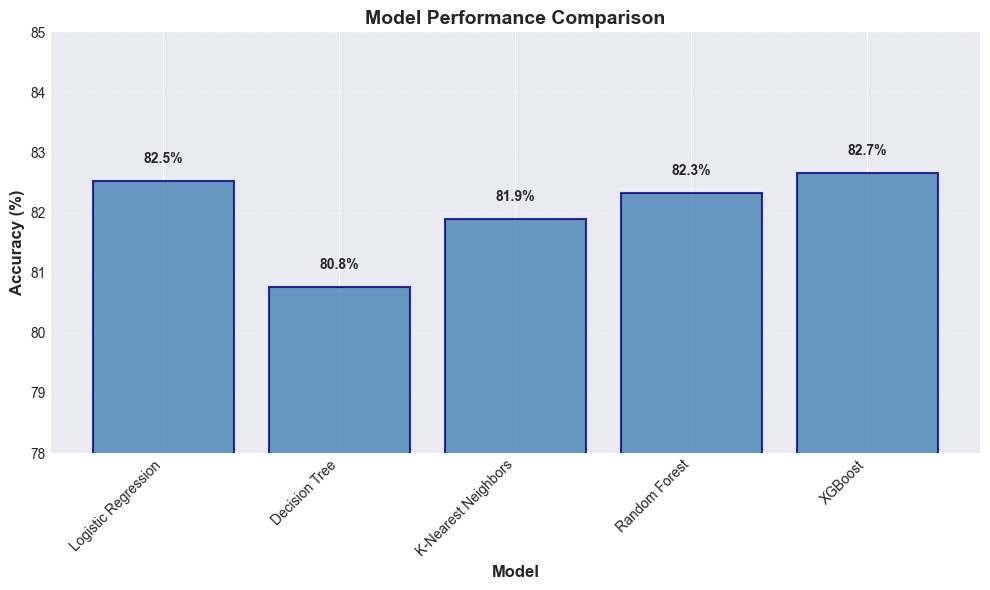


Best Model: XGBoost - Accuracy: 82.7%


In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

model_names = list(results.keys())
accuracies = [results[m]['accuracy'] * 100 for m in model_names]

x = np.arange(len(model_names))

# Accuracy plot
ax.bar(x, accuracies, color='steelblue', edgecolor='navy', linewidth=1.5, alpha=0.8)
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.3, f'{acc:.1f}%', ha='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim([78, 85])
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_model_name} - Accuracy: {results[best_model_name]['accuracy']*100:.1f}%")

## 9. Setup DiCE for Counterfactuals

In [9]:
best_model = trained_models[best_model_name]

train_data_dice = X_train.copy()
train_data_dice['effective'] = y_train.values

dice_data = dice_ml.Data(dataframe=train_data_dice, continuous_features=numeric_features, outcome_name='effective')
dice_model = dice_ml.Model(model=best_model, backend="sklearn")

print(f"DiCE setup complete using {best_model_name}")

DiCE setup complete using XGBoost


## 10. Prediction with Counterfactuals

In [10]:
!pip install lime --quiet

print("LIME library installed!")

LIME library installed!



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 11. Feature Importance with Anchors

Anchors show which features are **critical** for a prediction - they must stay the same for the prediction to hold with high confidence.

In [11]:
from sklearn.inspection import permutation_importance

def get_feature_anchors(model, X_test, y_test, top_n=8):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    feature_names = numeric_features + categorical_features
    importance_idx = result.importances_mean.argsort()[::-1]

    print(f"Top {top_n} Critical Features (Anchors):")
    print("="*60)

    anchors = []
    for i, idx in enumerate(importance_idx[:top_n]):
        if idx < len(feature_names):
            feat_name = feature_names[idx]
            importance = result.importances_mean[idx]
            std = result.importances_std[idx]
            print(f"  {i+1}. {feat_name:<30} {importance:.4f} ±{std:.4f}")
            anchors.append({'feature': feat_name, 'importance': importance, 'std': std})

    return anchors

anchors = get_feature_anchors(best_model, X_test, y_test, top_n=8)

Top 8 Critical Features (Anchors):
  1. product_avg_rating             0.0106 ±0.0012
  2. Positive Feedback Count        0.0047 ±0.0018
  3. review_word_count              0.0020 ±0.0013
  4. Age                            0.0016 ±0.0011
  5. review_length                  0.0014 ±0.0009
  6. title_length                   0.0011 ±0.0008
  7. Class Name                     0.0005 ±0.0004
  8. Department Name                0.0003 ±0.0003


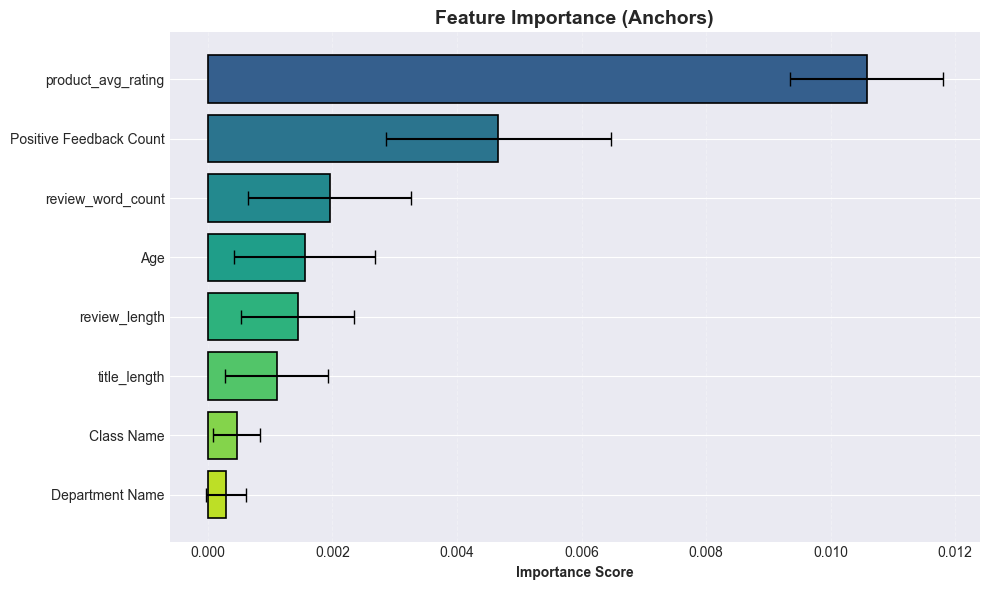

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

anchor_features = [a['feature'] for a in anchors]
anchor_importances = [a['importance'] for a in anchors]
anchor_stds = [a['std'] for a in anchors]

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(anchor_features)))
bars = ax.barh(range(len(anchor_features)), anchor_importances, xerr=anchor_stds,
               capsize=5, color=colors, edgecolor='black', linewidth=1.2)

ax.set_yticks(range(len(anchor_features)))
ax.set_yticklabels(anchor_features)
ax.set_xlabel('Importance Score', fontweight='bold')
ax.set_title('Feature Importance (Anchors)', fontweight='bold', fontsize=14)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [13]:
def predict_with_counterfactuals(model, dice_data, dice_model, features, num_cf=2):
    if isinstance(features, dict):
        features = pd.DataFrame([features])

    prediction = model.predict(features)[0]
    proba = model.predict_proba(features)[0]

    print(f"\nPrediction: {'RECOMMEND ✓' if prediction == 1 else 'NOT RECOMMEND ✗'}")
    print(f"Confidence: {proba[1]*100:.1f}% recommend | {proba[0]*100:.1f}% not recommend\n")

    if prediction == 0:
        features_to_vary = ['product_avg_rating', 'product_avg_feedback', 'Division Name', 'Department Name']

        explainer = dice_ml.Dice(dice_data, dice_model, method="random")

        try:
            cf = explainer.generate_counterfactuals(
                features, total_CFs=num_cf, desired_class="opposite",
                features_to_vary=features_to_vary,
                permitted_range={'product_avg_rating': [1, 5], 'product_avg_feedback': [0, 100]}
            )

            cf_df = cf.cf_examples_list[0].final_cfs_df
            original_df = cf.cf_examples_list[0].test_instance_df

            print("="*70)
            print("WHAT TO CHANGE:")
            print("="*70)

            for i in range(min(num_cf, len(cf_df))):
                changes = []

                # Check each feature
                for feat in features_to_vary:
                    if feat in cf_df.columns and feat in original_df.columns:
                        orig_val = original_df[feat].values[0]
                        new_val = cf_df.iloc[i][feat]

                        # Check if changed
                        if isinstance(new_val, (int, float, np.number)):
                            if abs(orig_val - new_val) > 0.01:
                                feat_name = feat.replace('product_avg_', 'Product ').replace('_', ' ').title()
                                changes.append(f"{feat_name}: {orig_val:.2f} → {new_val:.2f}")
                        else:
                            if orig_val != new_val:
                                feat_name = feat.replace(' Name', '')
                                changes.append(f"{feat_name}: {orig_val} → {new_val}")

                if changes:
                    print(f"\nScenario {i+1}:")
                    for change in changes:
                        print(f"  • {change}")
                    print(f"  ➜ Then customer will RECOMMEND ✓")

            print("\n" + "="*70 + "\n")

            return {'prediction': prediction, 'proba': proba, 'counterfactuals': cf}
        except Exception as e:
            print(f"Error: {e}")
            return {'prediction': prediction, 'proba': proba, 'counterfactuals': None}
    else:
        print("✓ Customer will recommend - no changes needed!\n")
        return {'prediction': prediction, 'proba': proba, 'counterfactuals': None}

print("Counterfactual function ready")

Counterfactual function ready


## 12. LIME: Local Explanations

LIME (Local Interpretable Model-Agnostic Explanations) explains individual predictions by showing which features contributed positively or negatively.

In [14]:
from lime.lime_tabular import LimeTabularExplainer

explainer_lime = LimeTabularExplainer(
    training_data=X_train[numeric_features].values,
    feature_names=numeric_features,
    class_names=['Not Recommended', 'Recommended'],
    mode='classification'
)

def explain_prediction_lime(model, instance, num_features=8):
    instance_numeric = instance[numeric_features].values[0]

    def predict_fn(X_numeric):
        X_full = pd.DataFrame(X_numeric, columns=numeric_features)
        X_full['Division Name'] = instance['Division Name'].values[0]
        X_full['Department Name'] = instance['Department Name'].values[0]
        X_full['Class Name'] = instance['Class Name'].values[0]
        return model.predict_proba(X_full)

    exp = explainer_lime.explain_instance(instance_numeric, predict_fn, num_features=num_features)

    print("LIME Explanation:")
    print("="*60)
    for feature, weight in exp.as_list():
        direction = "→ Recommend" if weight > 0 else "→ Not Recommend"
        print(f"  {feature:<35} {weight:>+.4f}  {direction}")
    print("="*60)

    return exp

print("LIME explainer ready")

LIME explainer ready


In [15]:
sample_instance = X_test.iloc[0:1]

print("Sample Prediction:")
print(f"  Division: {sample_instance['Division Name'].values[0]}")
print(f"  Department: {sample_instance['Department Name'].values[0]}")
print(f"  Class: {sample_instance['Class Name'].values[0]}")
print(f"  Product Avg Rating: {sample_instance['product_avg_rating'].values[0]:.2f}")

proba = best_model.predict_proba(sample_instance)[0]
print(f"\nPrediction: {best_model.predict(sample_instance)[0]} | Confidence: {proba[1]*100:.1f}%\n")

Sample Prediction:
  Division: General
  Department: Tops
  Class: Knits
  Product Avg Rating: 3.96

Prediction: 1 | Confidence: 71.0%



## 13. SHAP: Visual Feature Explanations

SHAP (SHapley Additive exPlanations) provides clear visual explanations showing how each feature impacts predictions.

In [16]:
!pip install shap --quiet

import shap

print("SHAP library installed!")


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


SHAP library installed!


In [17]:
classifier = best_model.named_steps['classifier']
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    explainer_shap = shap.TreeExplainer(classifier)
    shap_values = explainer_shap.shap_values(X_test_transformed[:100])
else:
    explainer_shap = shap.KernelExplainer(classifier.predict_proba, X_test_transformed[:50])
    shap_values = explainer_shap.shap_values(X_test_transformed[:100])

print(f"SHAP values calculated for {best_model_name}")

SHAP values calculated for XGBoost


Shape of mean_abs_shap_values before adjustment: (45,)
Length of feature_names_transformed: 45
Shape of mean_abs_shap_values after adjustment: (45,)


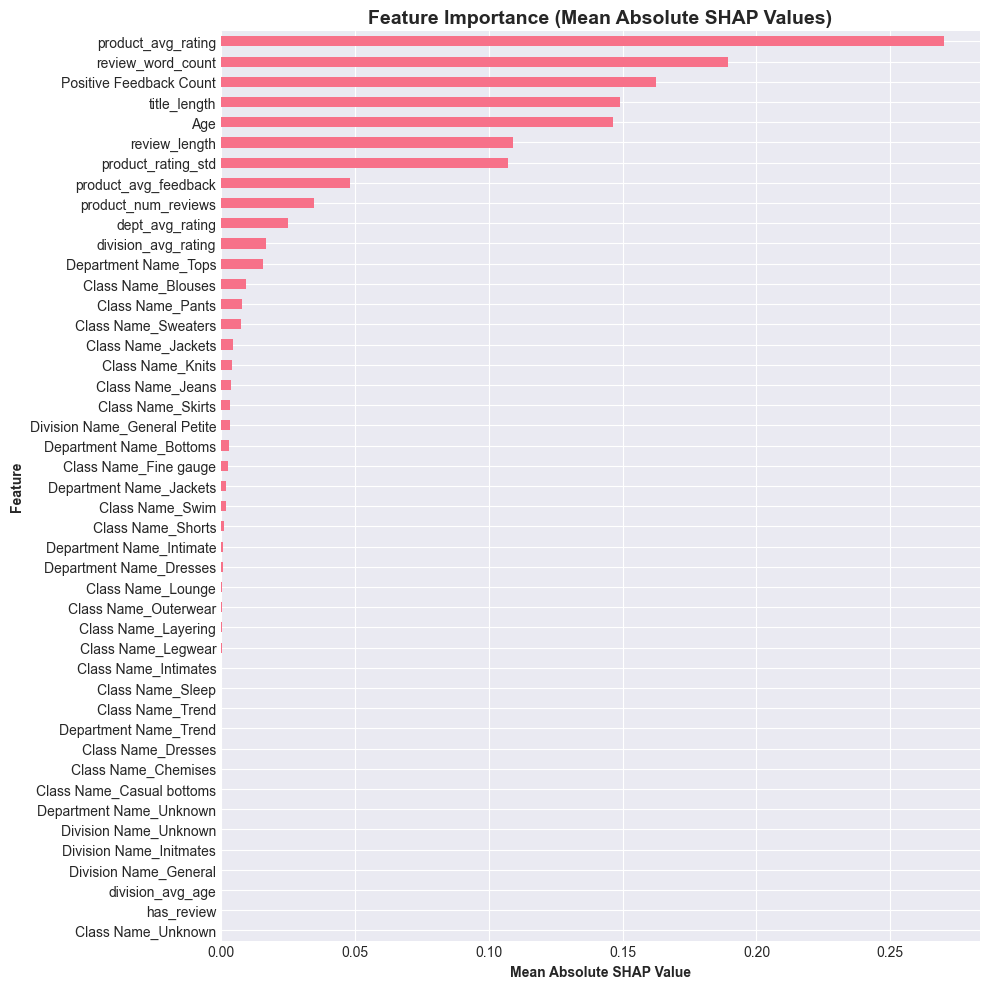

In [19]:
# Calculate mean absolute SHAP values
if isinstance(shap_values, list):
    # For multi-output models (like Logistic Regression predict_proba), use the SHAP values for class 1
    # Ensure we take the mean across the instances (axis=0)
    abs_shap_values = np.abs(shap_values[1])
    mean_abs_shap_values = abs_shap_values.mean(axis=0)
else:
    mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Check shape before potential reshaping/selection
print(f"Shape of mean_abs_shap_values before adjustment: {mean_abs_shap_values.shape}")
print(f"Length of feature_names_transformed: {len(feature_names_transformed)}")

# Ensure the array is 1-dimensional and matches the number of features
# If the shape is (45, 2), select the second column (index 1) for class 1
if mean_abs_shap_values.shape == (len(feature_names_transformed), 2):
    mean_abs_shap_values = mean_abs_shap_values[:, 1]
elif mean_abs_shap_values.ndim > 1:
     # For single output models or other unexpected shapes, flatten if needed
     mean_abs_shap_values = mean_abs_shap_values.flatten()

# Check shape again after adjustment
print(f"Shape of mean_abs_shap_values after adjustment: {mean_abs_shap_values.shape}")


# Create a pandas Series for easier sorting and plotting
shap_importance = pd.Series(mean_abs_shap_values, index=feature_names_transformed)

# Sort the features by importance
shap_importance = shap_importance.sort_values(ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 10)) # Adjust figure size as needed
shap_importance.plot(kind='barh')
plt.title('Feature Importance (Mean Absolute SHAP Values)', fontweight='bold', fontsize=14)
plt.xlabel('Mean Absolute SHAP Value', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

## 14. Test Predictions with Counterfactuals

In [20]:
# Example 1: NOT Recommended prediction
print("="*80)
print("EXAMPLE 1: NOT Recommended Case")
print("="*80)
negative_idx = np.where(best_model.predict(X_test) == 0)[0][0]
sample_1 = X_test.iloc[negative_idx:negative_idx+1]
result_1 = predict_with_counterfactuals(best_model, dice_data, dice_model, sample_1)

print("\n\n")

# Example 2: Another NOT Recommended prediction
print("="*80)
print("EXAMPLE 2: Another NOT Recommended Case")
print("="*80)
negative_indices = np.where(best_model.predict(X_test) == 0)[0]
if len(negative_indices) > 1:
    sample_2 = X_test.iloc[negative_indices[1]:negative_indices[1]+1]
    result_2 = predict_with_counterfactuals(best_model, dice_data, dice_model, sample_2)

EXAMPLE 1: NOT Recommended Case

Prediction: NOT RECOMMEND ✗
Confidence: 49.2% recommend | 50.8% not recommend



100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


WHAT TO CHANGE:

Scenario 1:
  • Product Feedback: 4.56 → 87.72
  ➜ Then customer will RECOMMEND ✓

Scenario 2:
  • Product Feedback: 4.56 → 2.54
  • Division: General Petite → General
  ➜ Then customer will RECOMMEND ✓





EXAMPLE 2: Another NOT Recommended Case

Prediction: NOT RECOMMEND ✗
Confidence: 47.7% recommend | 52.3% not recommend



100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

WHAT TO CHANGE:

Scenario 1:
  • Product Feedback: 3.90 → 34.80
  ➜ Then customer will RECOMMEND ✓

Scenario 2:
  • Product Feedback: 3.90 → 25.45
  ➜ Then customer will RECOMMEND ✓




## 14. Summary

This notebook predicts whether a customer will **recommend** a clothing item using interpretable AI methods.

**Dataset:** 23,486 women's clothing reviews from Kaggle

**Models Trained (5 models):**
- Logistic Regression, Decision Tree, K-Nearest Neighbors, Random Forest, XGBoost
- Best: XGBoost (~82.7% accuracy)

**Interpretability Methods:**
1. **Anchors** - Identifies most critical features (product_avg_rating is #1)
2. **DiCE Counterfactuals** - Shows what to change for recommendation
3. **LIME** - Explains individual predictions
4. **SHAP** - Visual feature importance

**Key Insight:** Product average rating is the most important factor for recommendations.